# Run ML inference and draw on videos!

In this guide you'll learn how to utilise `DIS.CO` in order to parallelise video classifiaction and rendring task and run it over the massive disco cloud.

We will test 6 different classifiers provided by [`opencv`](https://github.com/opencv/opencv/tree/master/data/haarcascades) by drawing the faces they have detected on a sample video.

As this guide aims to help you get started with `disco` rather than learn how to draw rectangles over videos, most of that code is located in the [`tools.py`](tools.py) file.

The functions implemented there are:
  - `split_video` - splits a video into chunks of X seconds
  - `join_videos` - joins all videos in given folder into one big video
  - `proc_image` - runs classifiers and draws the results over a picture (or a frame from video)
  - `proc_video` - builds new video in which every frame is processed by `proc_image`
  - `make_empty_folder` - ensures the given path is an empty folder

In addition to those functions the tools class contains few functions that provide file identifiers for `dis.co` jobs. This also caches previously uploaded files and their ids so you can easily iterate over the code and videos and uploading only what's needed. Those functions are:
  - `get_fid` - uploads a file to your disco cluster, making it available for jobs and also caches the file id locally. For more info see [Files and Jobs in `disco`](#broken)
  - `get_common_file_ids` - returns the list of file ids needed for execution of the code (the classifier files and the tools class file ids). Uploads updated or missing files.
  - `get_run_fid` - returns the file id of the file that will be executed by the jobs. Uploads updated or missing files.

In [1]:
import os
import sys
import disco
import cv2
from pathlib import Path
from tools import split_video, join_videos, proc_image, proc_video, get_fid
from tools import get_common_file_ids, get_run_fid,make_empty_folder
from IPython.display import Video, Image

Ok, once the boring imports are out of the way, lets see what happens during image processing. Notice that as we are running multiple classifiers, you might get more than once rectangle in the photos.

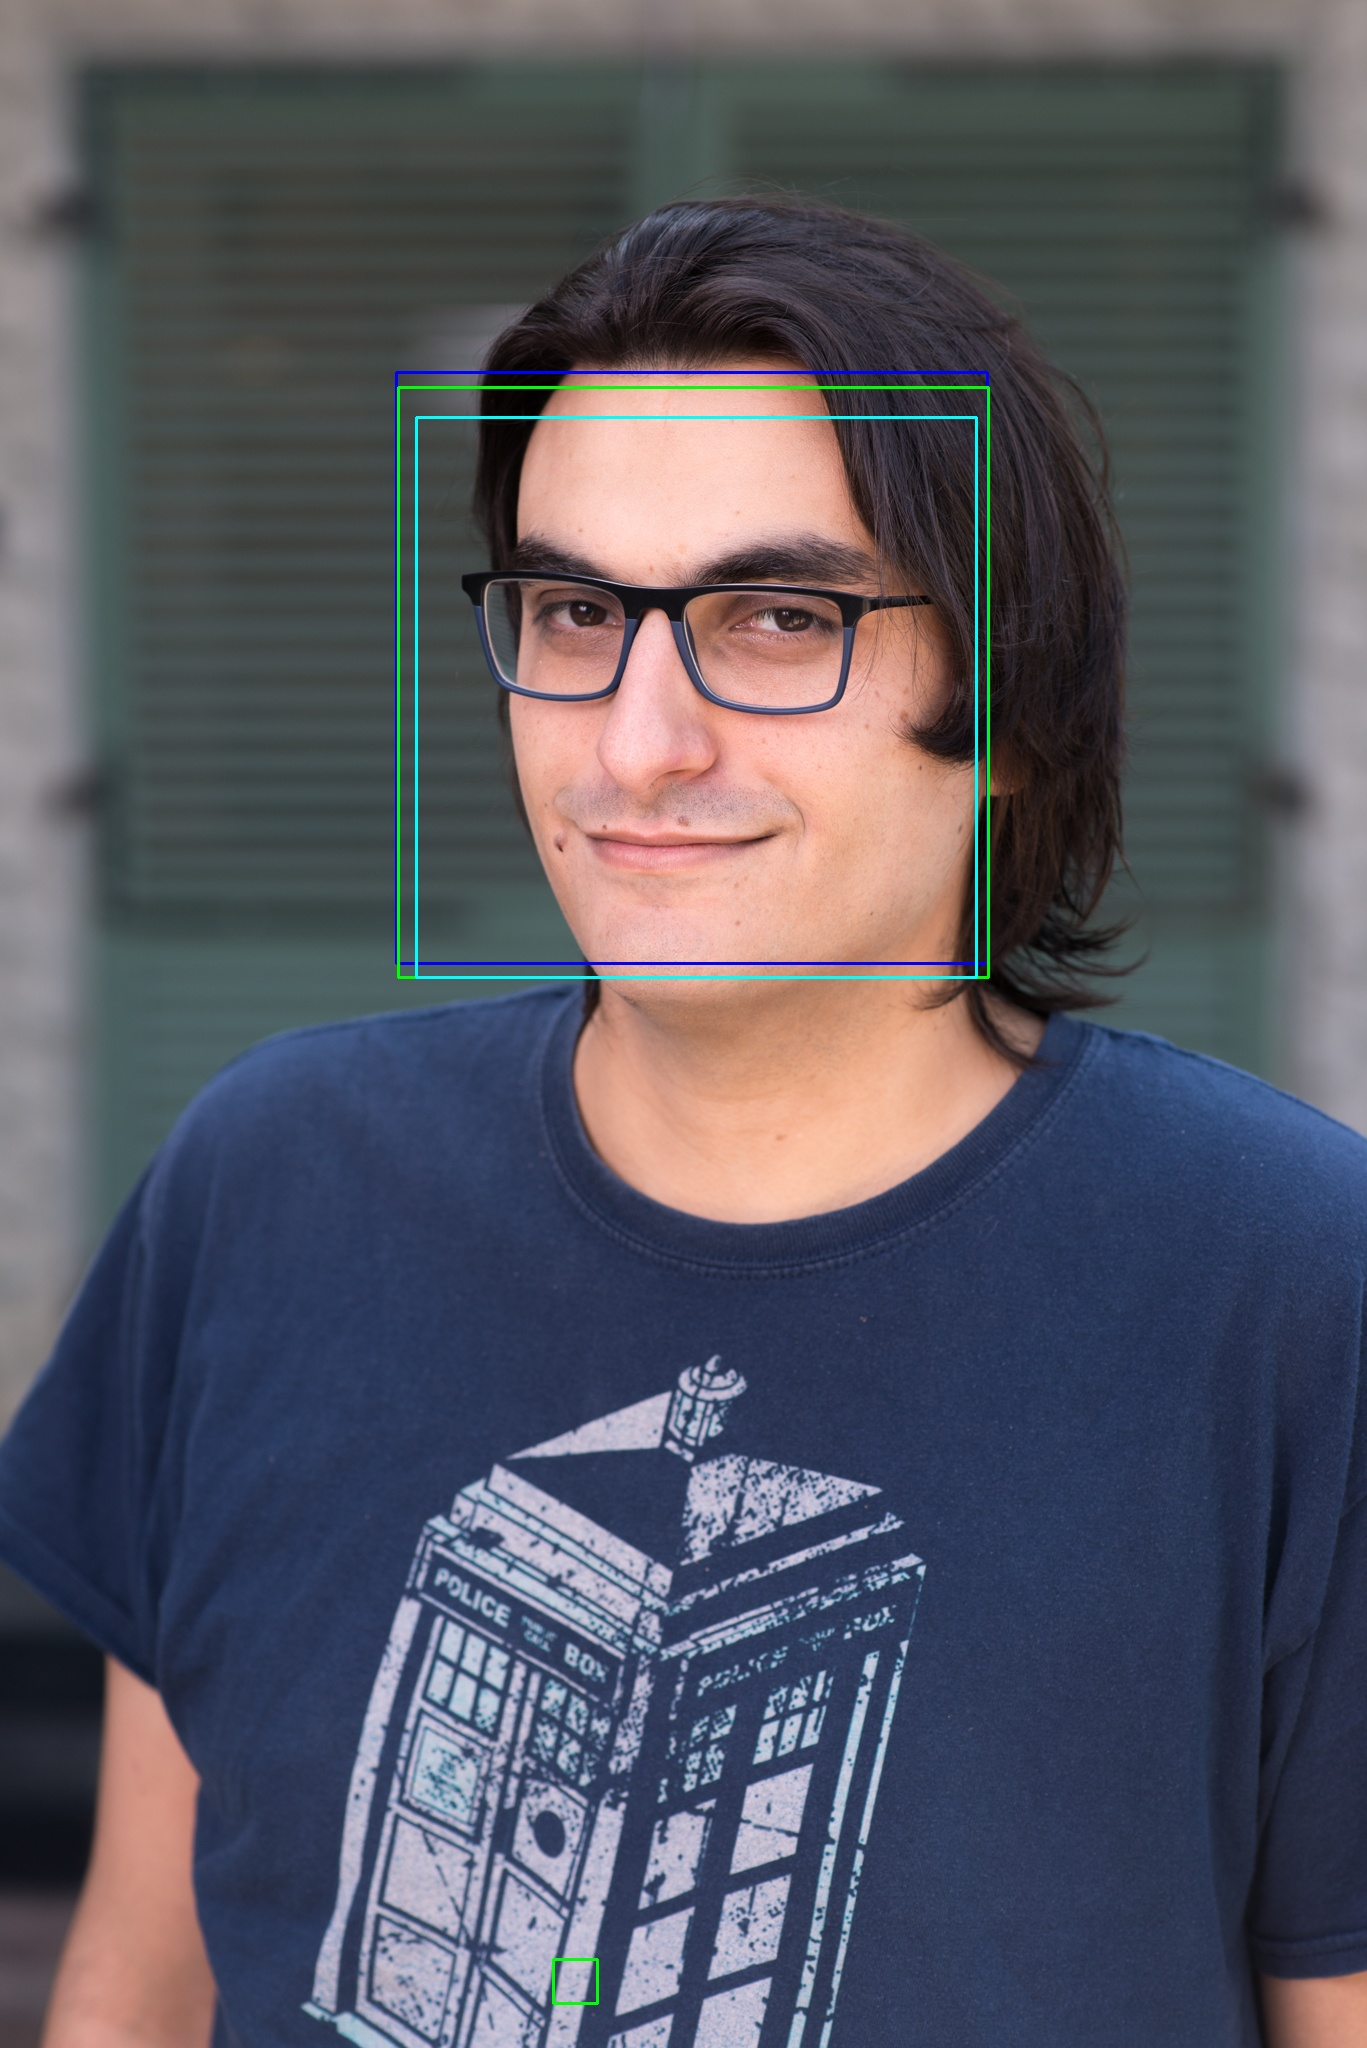

In [2]:
sample_img = cv2.imread('test.jpg')
priv = proc_image(sample_img)
cv2.imwrite('res.jpg',priv)

Image('res.jpg', width=250)

Pretty straight forward, Right? 
We detect faces, and mark them. 
While this is relatively fast on a single image, running this on a video will take some time, even on fast workstations.

Feel free to run `proc_video('video.mp4', 'result.mp4')` and see for yourself!

In the next step, we will show the video and split it into small chunks. 

In [3]:
Video('video.mp4', width=600)

In [4]:
sample_video=Path('video.mp4')
parts = split_video(sample_video, 10, Path('./tmp_split'))


Now lets upload the chunks into your `disco` cluster so we can use them in jobs. The `get_fid` function also keeps track of which files ware already uploaded so you don't need to re-upload them.

In [ ]:
part_file_ids=[get_fid(p) for p in parts]
print("Total jobs: ",len(part_file_ids))

Uploading tmp_split/split007.mp4 (451b3bf30a9836832539316e7adcf2b73ebe423a)
Uploading tmp_split/split013.mp4 (f75bc92be5214238372403ab0032db3257790289)
Uploading tmp_split/split012.mp4 (d9b04d7060ccc3b8e692d7825cdfc708e5ae74d2)
Uploading tmp_split/split006.mp4 (796b3a1b57153434df0c58767cf915b62af943b9)
Uploading tmp_split/split010.mp4 (e0bb10e860a504d64efb02ce9de77030a889f722)
Uploading tmp_split/split004.mp4 (536b7b21f45ce156fdf1b86acf91626e9f2be053)
Uploading tmp_split/split038.mp4 (3b2ea7b0a31dc58fe068a1bb6e2ddd2c22496d63)
Uploading tmp_split/split039.mp4 (d36a216255668fab8d153fa66d47d1952bef62b8)
Uploading tmp_split/split005.mp4 (6c75cef00ff2b1b0455815a5fa450612330b1f82)
Uploading tmp_split/split011.mp4 (d559f147db83db5cebf7a538b0c08f3033c6e972)
Uploading tmp_split/split029.mp4 (111275298abaa40d0173de4dc7f43b7c3b526aa6)
Uploading tmp_split/split015.mp4 (d2f64589e70daff9819308d063d063227e0a3d98)
Uploading tmp_split/split001.mp4 (a5c9f29cbec1f0846b4e0236d517e93dd5df1c33)
Uploading tm

Now that we have the files ready, lets run a `dis.co` job to process the files. 

If you are unfamiliar with disco jobs, you need to provide 3 file ids (or arrays of files ids)
1. `script_file_id` - the actual file to be executed
1. `constants_file_ids` -  other files needed by the script
1. `input_file_ids` - `input_file_ids` is an optional array of file ids. For every one, a `task` will be created inside your `disco` job, and the file path will be the first argument passed to your `script_file_id`

**In this example, each `input_file_id` is one of the video chunks, and [`run.py`](./run.py) simply calls `proc_video` on the video part and outputs the result**

In [ ]:
job = disco.Job.add(
    script_file_id=get_run_fid(),
    input_file_ids=part_file_ids,
    constants_file_ids=get_common_file_ids(),
    auto_start=True
)
print(job)


GREAT! We now have a running job. Let's wait for it to complete... 

In [ ]:
%%time
job.wait_for_finish(timeout=3600)
print("Job done")

Let's clean up our temp directory and extract the processed video parts into the directory


In [ ]:
# let make sure the target path is clear
out_p=Path('./out')/'job' / job.job_id
make_empty_folder(out_p)

print("Downloading results")
done_tasks=job.get_results()
for task in done_tasks:
    task.write_files(out_p)

**And finally, lets combine the parts into a single video file and see the result!**

In [ ]:
join_videos(Path(out_p) ,Path('./result.mp4'))
Video('result.mp4', width=600)